# This notebook evaluates the predictions of the TinyBert Baseline output

In [1]:
import pandas as pd
from sklearn.metrics import f1_score
import os
import numpy as np

In [2]:
#get path information
product_path = '../../../../src/data/product'
train_test_all_filtered_path_2 = os.path.join(product_path, 'train_test_split/output_unfiltered_tables/large/after_manual_checking/baselines')
data_path = '../../../../src/data'
mapping_corpus_path_2 = data_path + r'/product/lspc2020_to_tablecorpus/Cleaned'
train_test_all_filtered_path = os.path.join(product_path, 'train_test_split/output_unfiltered_tables/large/after_manual_checking')

In [3]:
#load the TinyBert results
res = pd.read_csv('../Baseline/TinyBert_Results/predict_results_None.txt', sep='\t')
res.drop('index', axis=1, inplace=True)

In [4]:
#load the test set
real = pd.read_csv(os.path.join(train_test_all_filtered_path_2,'df_test.csv'))

In [5]:
real

,sentence1,label
0,WD 2TB Elements Portable External Hard Drive -...,442
1,GoPro Head Strap + Quick Clip nan,591
2,GoPro 3 way grip Arm GoPro nan,245
3,Akérat Smoothing Exfoliating Cream <p>Targeted...,692
4,Moisturizing Self-Tanning Silky Gel <p>Non-gre...,223
...,...,...
10650,Apple Lightning to USB-C Cable (2m) Apple Ligh...,70
10651,Apple Lightning to VGA adapter Apple Lightning...,184
10652,Apple Lightning to Digital AV adapter Apple Li...,45
10653,Rolex Watches Oyster Perpetual GMT-Master II 1...,565


In [6]:
final = pd.concat([real,res], axis=1)

In [7]:
f1_score(real.label, res.prediction, average='micro')

0.8329422806194275

In [8]:
f1_scores = f1_score(real.label, res.prediction, average=None, labels=real.label)
f1_scores_with_labels = {label:score for label,score in zip(real.label, f1_scores)}

In [9]:
df_f1 = pd.DataFrame.from_dict(f1_scores_with_labels, orient="index").reset_index().rename(columns={'index':'label',0:'f1'}).sort_values(by=['label'])

In [10]:
# get information on label, prediction, and cluster itself in one table
#df_join_sentence = pd.merge(df_f1, real.drop_duplicates(subset=['label']), how="left", on=["label", "label"])

In [11]:
# get information on label, prediction, and cluster itself in one table
#pd.merge(final, df_f1, how="left", on=["label", "label"]).sort_values(by=['label']).to_excel('f1_per_cluster_baseline.xlsx')

# F1 Scores for different domains

In [12]:
domains=['Bikes','Cars','Clothes','Drugstore','Electronics','Random','Technology','Tools']

In [13]:
#get all clusters with information
combined_csv_data = pd.concat([pd.read_csv(os.path.join(mapping_corpus_path_2, f"{file}_cluster_8_tables.csv")) for file in domains]).drop(columns=['Unnamed: 0'])

In [14]:
#get cluster_ids
cluster_list=[]
files_representation_train = [file for file in os.listdir(os.path.join(train_test_all_filtered_path,'train_cleaned')) if file.endswith('.json.gz')]
for zip_file in files_representation_train:
    df = pd.read_json(os.path.join(train_test_all_filtered_path,'train_cleaned') + '/{}'.format(zip_file), compression='gzip', lines=True)
    cluster_list.extend(df['cluster_id'].tolist())
    # get only clusters that are unique
unique_clusters = np.unique(cluster_list)
unique_clusters = np.delete(unique_clusters, 0)

In [15]:
combined_csv_data_filter = combined_csv_data[combined_csv_data['cluster_id'].isin(unique_clusters)].drop_duplicates(subset=['cluster_id'])

In [16]:
#scale cluster_ids
combined_csv_data_filter['label'] = combined_csv_data_filter.groupby('cluster_id').ngroup()
#combine information with predictions and labels
df_domain_f1 = pd.merge(final.drop(columns='sentence1'), combined_csv_data_filter.drop(columns=['cluster_id']), how="left", on=["label", "label"])

In [17]:
for domain in domains:
    f1_domain = f1_score(df_domain_f1[df_domain_f1['domain']==domain].label, df_domain_f1[df_domain_f1['domain']==domain].prediction, average='micro')
    print(f"F1 Score for {domain}: {f1_domain}")

F1 Score for Bikes: 1.0
F1 Score for Cars: 0.8701298701298701
F1 Score for Clothes: 0.7711978465679677
F1 Score for Drugstore: 0.5866336633663366
F1 Score for Electronics: 0.760904170646291
F1 Score for Random: 0.8603326498063341
F1 Score for Technology: 0.9616240266963292
F1 Score for Tools: 0.0


/home/bizer-tp2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


# F1 scores for size of train data

In [18]:
#load the train set
df_train = pd.read_csv(os.path.join(train_test_all_filtered_path_2,'df_train.csv'))
#join label, predictions and amount test set
df_amount_train_f1 = pd.merge(final.drop(columns='sentence1'), df_train.groupby('label').count(), how="left", on=["label", "label"])

In [22]:
bins = [0, 5, 10, 15, 25, 50, 100, 150]
#create bins for categorization
df_amount_train_f1['binned'] = pd.cut(df_amount_train_f1['sentence1'], bins)

In [23]:
for interval in df_amount_train_f1['binned'].unique().to_list():
    f1_train_size = f1_score(df_amount_train_f1[df_amount_train_f1['binned']==interval].label, df_amount_train_f1[df_amount_train_f1['binned']==interval].prediction, average='micro')
    print(f"F1 Score for size of train set per cluster in {interval}: {f1_train_size}")

F1 Score for size of train set per cluster in (10, 15]: 0.9178981937602627
F1 Score for size of train set per cluster in (5, 10]: 0.8269733403031886
F1 Score for size of train set per cluster in (0, 5]: 0.6513605442176871
F1 Score for size of train set per cluster in (25, 50]: 0.9682352941176471
F1 Score for size of train set per cluster in (15, 25]: 0.9407294832826748
F1 Score for size of train set per cluster in (50, 100]: 0.9788106630211895
F1 Score for size of train set per cluster in (100, 150]: 0.9523809523809523


# F1 scores for description column 

### We only look at the description, as the name is only once not given with the description column empty as well. So, it is irrelevant. Around 2800 entities do not have a description.

In [24]:
#load test data
df_test= pd.read_json(os.path.join(train_test_all_filtered_path,'test/concatenated_data/test_all_filtered_tables.json.gz'), compression='gzip', lines=True)
df_test = df_test[['name','description','cluster_id']]
#scale cluster_ids
df_test['label'] = df_test.groupby('cluster_id').ngroup()

In [25]:
df_test

,name,description,cluster_id,label
0,WD 2TB Elements Portable External Hard Drive -...,Brand: Western Digital Color: black Features: ...,541658,442
1,GoPro Head Strap + Quick Clip,nan,863679,591
2,GoPro 3 way grip Arm GoPro,nan,251884,245
3,Akérat Smoothing Exfoliating Cream,<p>Targeted body cream smoothes and retexturiz...,1107309,692
4,Moisturizing Self-Tanning Silky Gel,"<p>Non-greasy, hydrating self-tanner gives the...",230191,223
...,...,...,...,...
10650,Apple Lightning to USB-C Cable (2m),Apple Lightning to USB-C Cable (2m),51314,70
10651,Apple Lightning to VGA adapter,Apple Lightning to VGA adapter,185147,184
10652,Apple Lightning to Digital AV adapter,Apple Lightning to Digital AV adapter,32374,45
10653,Rolex Watches Oyster Perpetual GMT-Master II 1...,Brand : Replica Rolex Collection : Oyster Perp...,800686,565


In [26]:
#replace missing values
df_test = df_test.replace(r'^\s*$', np.NaN, regex=True).replace("nan", 0)
df_test['name'] = df_test['name'].fillna(0)
df_test['description'] = df_test['description'].fillna(0)

In [27]:
df_empty_desc_f1 = pd.merge(final.drop(columns='sentence1'), df_test.drop(columns=['name','cluster_id','label']), how="left",left_index=True, right_index=True)
#f1 with description
f1_domain_with = f1_score(df_empty_desc_f1[df_empty_desc_f1['description']!=0].label, df_empty_desc_f1[df_empty_desc_f1['description']!=0].prediction, average='micro')
print(f"F1 Score for entities with description: {f1_domain_with}")
#f1 without description
f1_domain_without = f1_score(df_empty_desc_f1[df_empty_desc_f1['description']==0].label, df_empty_desc_f1[df_empty_desc_f1['description']==0].prediction, average='micro')
print(f"F1 Score for without description: {f1_domain_without}")

F1 Score for entities with description: 0.8053708439897698
F1 Score for without description: 0.908994708994709


# Compare different settings to description

In [39]:
df_domain_description = pd.merge(df_domain_f1, df_empty_desc.drop(columns=['label','prediction']), how="left", left_index=True, right_index=True)

In [40]:
df_domain_description

,label,prediction,domain,description
0,442,442,Electronics,Brand: Western Digital Color: black Features: ...
1,591,591,Electronics,0
2,245,245,Electronics,0
3,692,570,Drugstore,<p>Targeted body cream smoothes and retexturiz...
4,223,569,Drugstore,"<p>Non-greasy, hydrating self-tanner gives the..."
...,...,...,...,...
10650,70,70,Electronics,Apple Lightning to USB-C Cable (2m)
10651,184,184,Electronics,Apple Lightning to VGA adapter
10652,45,648,Electronics,Apple Lightning to Digital AV adapter
10653,565,565,Clothes,Brand : Replica Rolex Collection : Oyster Perp...


In [42]:
df_domain_description_count = pd.merge(df_domain_description, df_amount_train_f1.drop(columns=['label','prediction','sentence1']), how="left", left_index=True, right_index=True)

In [43]:
df_domain_description_count

,label,prediction,domain,description,binned
0,442,442,Electronics,Brand: Western Digital Color: black Features: ...,"(10, 15]"
1,591,591,Electronics,0,"(5, 10]"
2,245,245,Electronics,0,"(10, 15]"
3,692,570,Drugstore,<p>Targeted body cream smoothes and retexturiz...,"(5, 10]"
4,223,569,Drugstore,"<p>Non-greasy, hydrating self-tanner gives the...","(0, 5]"
...,...,...,...,...,...
10650,70,70,Electronics,Apple Lightning to USB-C Cable (2m),"(5, 10]"
10651,184,184,Electronics,Apple Lightning to VGA adapter,"(0, 5]"
10652,45,648,Electronics,Apple Lightning to Digital AV adapter,"(0, 5]"
10653,565,565,Clothes,Brand : Replica Rolex Collection : Oyster Perp...,"(0, 5]"


In [50]:
df_domain_description_count_without = df_domain_description_count[df_domain_description_count['description']==0]
df_domain_description_count_with = df_domain_description_count[df_domain_description_count['description']!=0]

<AxesSubplot:>

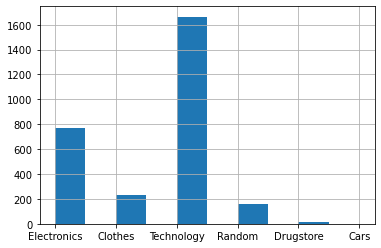

In [51]:
df_domain_description_count_without['domain'].hist()

<AxesSubplot:>

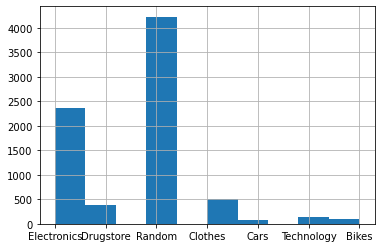

In [55]:
df_domain_description_count_with['domain'].hist()

<AxesSubplot:>

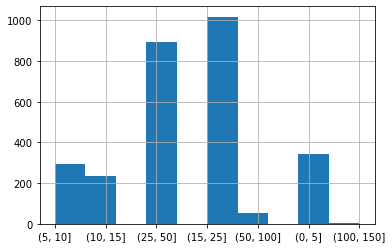

In [56]:
df_domain_description_count_without['binned'].astype(str).hist()

<AxesSubplot:>

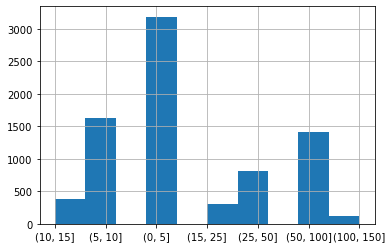

In [57]:
df_domain_description_count_with['binned'].astype(str).hist()